In [8]:
import pandas as pd
import datetime as dt
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [2]:
def get_truncated_df(merge_df, columns, year_column_name=None, low=0.01, high=0.99):
    merge_df_copy = merge_df.copy()
    if year_column_name == None:
        for column in columns: 
            _1pct, _99pct = merge_df_copy[column].quantile(q=low), merge_df_copy[column].quantile(q=high)
            merge_df_copy[column].where((merge_df_copy[column] < _99pct) & (merge_df_copy[column] > _1pct), math.nan, inplace=True)
    else: 
        merge_df_list = []
        merge_year_df_list = [[year, merge_year_df] for year, merge_year_df in merge_df_copy.groupby(year_column_name)]
        for year, merge_year_df in tqdm(merge_year_df_list):
            for column in columns: 
                _1pct, _99pct = merge_year_df[column].quantile(q=low), merge_year_df[column].quantile(q=high)
                merge_year_df[column].where(~((merge_year_df[column] > _99pct) | (merge_year_df[column] < _1pct)), math.nan, inplace=True)
            merge_df_list.append(merge_year_df)
        merge_df_copy = pd.concat(merge_df_list)
    
    return merge_df_copy

def get_boj_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['sedol', 'yr_qtr_index', 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('yr_qtr_index')): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['sedol', 'yr_qtr_index', 'boj_share_shares'])
    return sue_df_boj_merged

In [106]:
liq_df = pd.read_pickle(PATH+'checkpoint_data/liq.pkl')

In [114]:
boj_df = pd.read_pickle(PATH+'checkpoint_data/boj_purchases_stock_level_v2.pkl')

boj_df['date_f1'] = boj_df['date'] + pd.DateOffset(months=3)
boj_df['yr_qtr_index_f1'] = boj_df['date_f1'].apply(lambda x: (x.year, x.quarter))
boj_df['yr_qtr_index'] = boj_df['date'].apply(lambda x: (x.year, x.quarter))
boj_df = boj_df.sort_values(['date']).drop_duplicates(['sedol', 'yr_qtr_index'], keep='last')
boj_df = boj_df.drop(columns=['date_f1'])

In [133]:
control_df = pd.read_pickle(PATH+'checkpoint_data/control.dta')
control_df = control_df[['sedol', 'yr_qtr_index', 'mc', 'prc', 'vlt_l1', 'ret_l1', 'mb']]

# Basic Plots

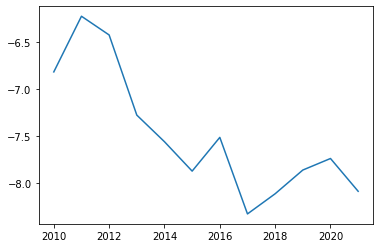

In [10]:
plt.plot(liq_df.groupby(['yr']).mean()['amihud'])

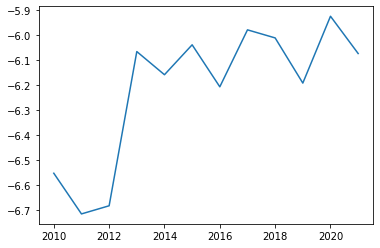

In [12]:
plt.plot(liq_df.groupby(['yr']).mean()['turn_no_ff'])

# Merge with BOJ

In [118]:
#merge with BOJ, note that it is a quarter lagged
liq_df_1 = pd.merge(liq_df, 
                    boj_df, 
                    left_on=['sedol', 'yr_qtr_index'],
                    right_on=['sedol', 'yr_qtr_index_f1'],
                    how='left', 
                    suffixes=[None, '_y']).drop(columns=['yr_qtr_index_f1', 'yr_qtr_index_y', 'date'])

In [119]:
liq_df_1 = liq_df_1.dropna(subset=['boj_share_shares'])

In [134]:
liq_df_2 = pd.merge(liq_df_1, 
                    control_df, 
                    on=['sedol', 'yr_qtr_index'], 
                    how='left')

In [135]:
cols = ['sedol', 'conm', 'yr', 'yr_qtr_index', 'amihud', 'turn_no_ff', 'num_days_total',
       'num_days_w_data', 'coverage_ratio', 'cshoc',
       'ffcshoc', 'boj_share_shares', 'boj_share_shares_no_ff', 'nk_flag']

cols += ['mc', 'prc', 'vlt_l1', 'ret_l1', 'mb']

liq_df_2 = liq_df_2[cols]

In [136]:
liq_df_2['yr_qtr_index'] = liq_df_2['yr_qtr_index'].astype(str)

In [137]:
liq_df_2.to_stata(PATH+'regression_files\dta_files\liq_regression.dta')

In [ ]:
TRY TURNOVER WITH FREE FLOAT